Siyu -- Mar. 18, 2025 <br>

Note: this code is very similar to the Matlab envelop function "peak" option to Python, but only handles 1D data

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.special as sp

# for computing the peak envelope
from scipy.signal import find_peaks
from scipy.interpolate import make_interp_spline

In [2]:
# set the path to your local PINNdata folder
localData = '/Users/xuebaobao/Desktop/Bessel/OpenCode/PINNdata/'

# [1] Find the peak envelope for Bessel function

In [3]:
# Limit the range of phase velocity by the approximate upper and lower bounds proposed by Ekstrom et al. (2009)
def get_Ekstrom_median(input_f, RayWave):
    # input_f is a 2D tensor with size (N,1)
    
    sample_f = np.linspace(0, 0.5, 30)
    sample_PV = sample_f * (2.8-4.1)/0.12 + 4.1
    sample_PV[sample_f > 0.12] = 2.8
    
    sample_PV[5] = 3.16
    sample_PV[6] = 3
    sample_PV[7] = 2.88
    sample_PV[8] = 2.82

    cw_median = np.interp(input_f, sample_f, sample_PV)

    if not RayWave:
        # for Love waves, increase the median by 0.5 km/s:
        cw_median = cw_median + 0.5

    return cw_median

In [4]:
def peak_envelope(NCF, n, k):
    """ Function to find the envelope using "peaks, only accepte 1D data
    n: min. distance between peaks 
    k: the order of the peak inteprolation (k=1 is linea; k=3 is cubic) """
    
    nx = len(NCF)

    # handle default case where not enough input is given
    if nx < 2 | nx <= n+1:
        yupper = NCF
        ylower = NCF

    else:
        # compute the upper envelope
        # find local maxima separated by at least N samples
        iPk = find_peaks(NCF, distance=n)[0]

        # smoothly connect the maxima via a spline
        cs = make_interp_spline(iPk, NCF[iPk], k=k)
        yupper = cs(np.linspace(1,len(NCF), len(NCF)))

        # compute the lower envelope
        # find local minima separated by at least N samples
        iPk = find_peaks(-NCF, distance=n)[0]

        # smoothly connect the minima via a spline
        cs = make_interp_spline(iPk, NCF[iPk], k=k)
        ylower = cs(np.linspace(1,len(NCF), len(NCF)))
        
        return yupper, ylower

## Plot the Bessel Envelopes

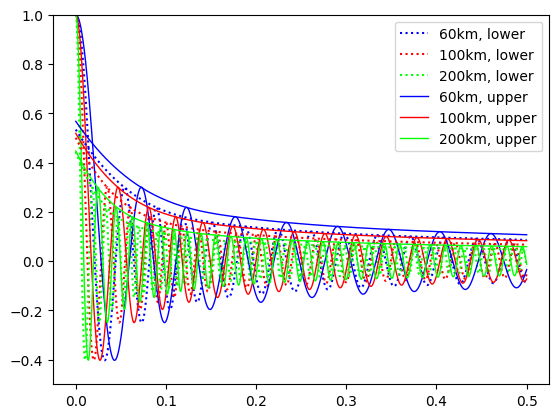

In [5]:
Bessel_f = np.linspace(0, 0.5, 1000)

# three different inter-station distances for testing
dist1 = 60
dist2 = 100
dist3 = 200

############### Choose Rayleigh OR Love ###############
# for Rayleigh
cw_lower = get_Ekstrom_median(Bessel_f, 1) - 0.6
cw_upper = get_Ekstrom_median(Bessel_f, 1) + 0.6

# # for Love
# cw_lower = get_Ekstrom_median(input_f, 0) - 0.6
# cw_upper = get_Ekstrom_median(input_f, 0) + 0.6

#######################################################

Bessel1 = sp.jv(0, Bessel_f*dist1*2*np.pi / cw_lower)
Bessel2 = sp.jv(0, Bessel_f*dist2*2*np.pi / cw_lower)
Bessel3 = sp.jv(0, Bessel_f*dist3*2*np.pi / cw_lower)

Bessel4 = sp.jv(0, Bessel_f*dist1*2*np.pi / cw_upper)
Bessel5 = sp.jv(0, Bessel_f*dist2*2*np.pi / cw_upper)
Bessel6 = sp.jv(0, Bessel_f*dist3*2*np.pi / cw_upper)

PEnv1, temp = peak_envelope(Bessel1, 50, 3)
PEnv2, temp = peak_envelope(Bessel2, 50, 3)
PEnv3, temp = peak_envelope(Bessel3, 50, 3)
PEnv4, temp = peak_envelope(Bessel4, 50, 3)
PEnv5, temp = peak_envelope(Bessel5, 50, 3)
PEnv6, temp = peak_envelope(Bessel6, 50, 3)


# Plot Bessels and their envelopes
plt.plot(Bessel_f, Bessel1, 'b:', label='60km, lower')
plt.plot(Bessel_f, Bessel2, 'r:', label='100km, lower')
plt.plot(Bessel_f, Bessel3, 'lime', linestyle=':', label='200km, lower')

plt.plot(Bessel_f, Bessel4, 'b', label='60km, upper', linewidth=1)
plt.plot(Bessel_f, Bessel5, 'r', label='100km, upper', linewidth=1)
plt.plot(Bessel_f, Bessel6, 'lime', label='200km, upper', linewidth=1)

plt.plot(Bessel_f, PEnv1, 'b:')
plt.plot(Bessel_f, PEnv2, 'r:')
plt.plot(Bessel_f, PEnv3, 'lime', linestyle=':')

plt.plot(Bessel_f, PEnv4, 'b', linewidth=1)
plt.plot(Bessel_f, PEnv5, 'r', linewidth=1)
plt.plot(Bessel_f, PEnv6, 'lime', linewidth=1)

plt.ylim([-0.5, 1])
plt.legend()

## Compute & Save the Bessel Envelopes

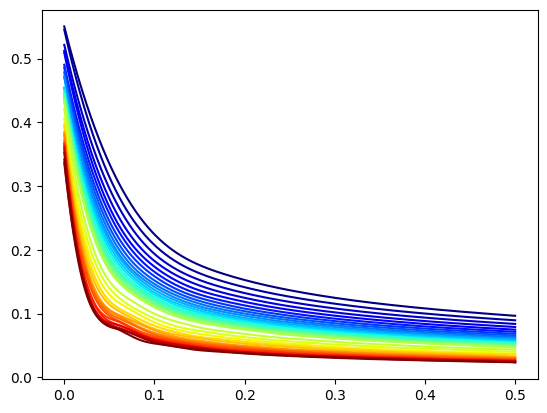

In [6]:
rdists = np.append(np.linspace(60, 250, 20), [np.linspace(300, 1000, 15)])

############### Choose Rayleigh OR Love ###############
# for Rayleigh
cw_lower = get_Ekstrom_median(Bessel_f, 1) - 0.6
cw_upper = get_Ekstrom_median(Bessel_f, 1) + 0.6

# # for Love
# cw_lower = get_Ekstrom_median(Bessel_f, 0) - 0.6
# cw_upper = get_Ekstrom_median(Bessel_f, 0) + 0.6

#######################################################

enve_rdists = np.zeros((len(Bessel_f), len(rdists)))
colors = plt.cm.jet(np.linspace(0,1,len(rdists)))

for i in range(len(rdists)):
    dist = rdists[i]

    Bessello = sp.jv(0, Bessel_f*dist*2*np.pi / cw_lower)
    Besselup = sp.jv(0, Bessel_f*dist*2*np.pi / cw_upper)

    enveup, temp = peak_envelope(Besselup, 50, 3)
    envelo, temp = peak_envelope(Bessello, 50, 3)

    # get the average of Bessel envelopes using the upper & lower phase velocities
    enveavg = (enveup + envelo) /2
    enve_rdists[:, i] = enveavg

    plt.plot(Bessel_f, enveavg, color=colors[i])


In [7]:
# save the Bessel envelopes to a csv file
rdists_header = '60km, 70km, 80km, 90km, 100km, 110km, 120km, 130km, 140km, 150km, 160km, 170km, 180km, 190km, 200km, \
210km, 220km, 230km, 240km, 250km, 300km, 350km, 400km, 450km, 500km, 550km, 600km, 650km, 700km, 750km, 800km, 850km, \
900km, 950km, 1000km' 

############### Choose Rayleigh OR Love ###############
# for Rayleigh
filename = localData + 'BesselEnveRay.csv'

# # for Love
# filename = localData + 'BesselEnveLove.csv'

#######################################################

# save the file
# np.savetxt(filename, enve_rdists, fmt='%.4e', delimiter=',', header=rdists_header)

# [2] Plot the Example Data

### The AkiNet Code

In [8]:
class NeuralNet1(nn.Module):
    def __init__(self, input_dimension, output_dimension,
                 n_hidden_layers, neurons, retrain_seed,
                 PV_median, PV_range=0.8):
        super().__init__()
        torch.manual_seed(retrain_seed)
        self.PV_median, self.PV_range = PV_median, PV_range
        self.activation = nn.Tanh()
        self.input_layer = nn.Linear(input_dimension, neurons)
        self.hidden_layers = nn.ModuleList(
            nn.Linear(neurons, neurons)
            for _ in range(n_hidden_layers-1)
        )
        self.output_layer = nn.Linear(neurons, output_dimension)
        # Xavier init
        def init_weights(m):
            if isinstance(m, nn.Linear):
                gain = nn.init.calculate_gain('tanh')
                nn.init.xavier_uniform_(m.weight, gain=gain)
                nn.init.zeros_(m.bias)
        self.apply(init_weights)
    
    def forward(self, x):
        # first layer + activation
        x = self.activation(self.input_layer(x))
        
        # hidden layers
        for lin in self.hidden_layers:
            x = self.activation(lin(x))
            
        # output
        x = self.output_layer(x)
        x = torch.tanh(x) * self.PV_range + self.PV_median
        return x

In [9]:
class GetBessel(torch.autograd.Function):
    @staticmethod
    def forward(ctx, n, x):
        # detach tensors explicitly to convert to numpy
        n_numpy = n.detach().cpu().numpy()
        x_numpy = x.detach().cpu().numpy()

        # compute using scipy explicitly (no grad tracking needed here)
        result_numpy = sp.jv(n_numpy, x_numpy)

        # save tensors explicitly for backward pass
        ctx.save_for_backward(n, x)

        # convert numpy results explicitly back to tensor
        result_tensor = torch.tensor(result_numpy, dtype=x.dtype, device=x.device)

        return result_tensor

    @staticmethod
    def backward(ctx, grad_output):
        n, x = ctx.saved_tensors

        # explicitly detach and convert for scipy (no grad tracking here)
        n_numpy = n.detach().cpu().numpy()
        x_numpy = x.detach().cpu().numpy()

        # compute derivative explicitly with scipy (standard bessel derivative identity)
        grad_x_numpy = (sp.jv(n_numpy - 1, x_numpy) - sp.jv(n_numpy + 1, x_numpy)) / 2

        # convert explicitly back to torch tensor
        grad_x = torch.tensor(grad_x_numpy, dtype=x.dtype, device=x.device)

        # propagate explicitly through grad_output
        grad_x = grad_output * grad_x

        # no gradient for order (n) since typically it’s an integer constant
        grad_n = None  

        return grad_n, grad_x


In [10]:
# Limit the range of phase velocity by approximate the upper and lower bounds proposed by Ekstrom et al. (2009)
def get_cw_median(input_f, RayWave):
    # input_f is a 2D tensor with size (N,1)
    
    cw_median = torch.from_numpy(input_f * -2.6 + 3.7).float().reshape(-1,1)

    if not RayWave:
        # for Love waves, increase the median by 0.5 km/s:
        cw_median = cw_median + 0.5

    return cw_median

In [11]:
# compute the envelope using Hilbert trasform 

import math
from scipy.fftpack import *

def hilbert_from_scratch(u):
    # N : fft length
    # M : number of elements to zero out
    # U : DFT of u
    # v : IDFT of H(U)

    N = len(u)
    # take forward Fourier transform
    U = fft(u)
    M = N - N//2 - 1
    # zero out negative frequency components
    U[N//2+1:] = [0] * M
    # double fft energy except @ DC0
    U[1:N//2] = 2 * U[1:N//2]
    # take inverse Fourier transform
    v = ifft(U)
    
    return v

In [12]:
# same as the smooth function in Matlab (need WSZ be odd number)
def smooth(a, WSZ):
    # a: NumPy 1-D array containing the data to be smoothed
    # WSZ: smoothing window size needs, must be an odd number
    
    out0 = np.convolve(a,np.ones(WSZ,dtype=int),'valid')/WSZ    
    r = np.arange(1,WSZ-1,2)
    start = np.cumsum(a[:WSZ-1])[::2]/r
    stop = (np.cumsum(a[:-WSZ:-1])[::2]/r)[::-1]
    
    return np.concatenate((start, out0, stop))

In [13]:
# compute the total loss of the network
def compute_loss(out_PV, input_f, input_NCF, Lambdas, dist_r, RayWave):

    # define the weight of each loss term
    [lambda1, lambda2] = Lambdas

    # compute J0(x) using PV
    out_x = input_f * dist_r * 2 * np.pi / out_PV
    if RayWave:
        out_Bessel = GetBessel.apply(torch.tensor(0), out_x)
    else:
        out_Bessel = (GetBessel.apply(torch.tensor(0), out_x) - GetBessel.apply(torch.tensor(2), out_x))/2

    ### Loss1: observation (NCF) vs. J_0(x)
    loss1 = torch.mean((input_NCF - out_Bessel)**2)
    
    ### Loss2: constrain the smoothness of c(w)
    grad_out_PV = torch.autograd.grad(out_PV, input_f, grad_outputs=torch.ones_like(out_PV), create_graph=True)[0]
    grad_out_PV2 = torch.autograd.grad(grad_out_PV, input_f, grad_outputs=torch.ones_like(out_PV), create_graph=True)[0]
    loss2 = torch.mean(grad_out_PV2 ** 2)

    # add up to get the total loss
    loss = lambda1 * loss1 + lambda2 * loss2 
    
    # print(
    #     "Total loss: ", round(loss.item(), 4),
    #     "| Fitting Loss: ", round(loss1.item(), 4),
    #     "| Smooth Loss: ", round(loss2.item(), 4))
    
    return loss
    

In [14]:
I_set_seed = 123

def train_PINN(input_f, noisyNCF, RayWave, Lambdas, dist_r, c_median, nnlayer, lr=float(1), nnneuoron=40):
   
    # Create PINN 
    approximate_PV = NeuralNet1(input_dimension=1, output_dimension=1, n_hidden_layers=nnlayer, neurons=nnneuoron, 
                            retrain_seed=I_set_seed, PV_median=c_median)
    
    # Define training parameters
    n_epochs = 1
    max_iter = 10000
    
    # to store the loss
    history = list()
    
    # define the optimizer
    optimizer_LBFGS = torch.optim.LBFGS(list(approximate_PV.parameters()),
                                  lr=lr,
                                  max_iter=max_iter,
                                  max_eval=50000,
                                  history_size=300,
                                  line_search_fn="strong_wolfe",
                                  tolerance_grad=1e-10,
                                  tolerance_change=1e-10)
    
    # Define a closure for the optimizer
    def closure():
        optimizer_LBFGS.zero_grad()
    
        # forward steps
        out_PV = approximate_PV(input_f)  # NN1 outputs phase velocity
        
        # compute the loss
        loss = compute_loss(out_PV, input_f, noisyNCF, Lambdas, dist_r, RayWave)

        history.append(loss.item())
        
        # backpropagate joint loss
        loss.backward()
    
        return loss
    
    for epoch in range(n_epochs):
        # print("################################ ", epoch, " ################################")
    
        # take optimizer step
        current_loss = optimizer_LBFGS.step(closure)

    # get the final inversion results
    infer_PV = approximate_PV(input_f)
    infer_x = input_f * dist_r * 2 * np.pi / infer_PV

    if RayWave:
        infer_Bessel = GetBessel.apply(torch.tensor(0), infer_x)
    else:
        infer_Bessel = (GetBessel.apply(torch.tensor(0), infer_x) - GetBessel.apply(torch.tensor(2), infer_x))/2

    return infer_PV, infer_Bessel, history, approximate_PV

### Inversion Example

In [40]:
# Plot & Save one single station pair 

stapair = '2H-ASYE_7C-GOR'
stadist = 90

# read in AkiEstimate Results
dataLove = np.loadtxt(localData + 'NCF/LoveResponse/dispersion_' + stapair + '.txt', 
                      delimiter=' ', skiprows=2)
NCF_f = dataLove[:,0]
Love_NCF = smooth(dataLove[:,1], 11)

dataRay = np.loadtxt(localData + 'NCF/RayResponse/dispersion_' + stapair + '.txt', 
                      delimiter=' ', skiprows=2)
Ray_NCF = smooth(dataRay[:,1], 11)

pred_f = []
pred_LPV = []
pred_LJ0 = []
pred_LHilb = []
with open(localData + 'AkiEst/ResultOf03_04/Final_' + stapair + '/opt.pred-love', 'r') as f:
    for line in f:
        # Split on whitespace
        tokens = line.split()
        
        # Convert each token to float
        floats = [float(tok) for tok in tokens]
        pred_f.append(floats[0])
        pred_LPV.append(floats[2]/1000)
        pred_LHilb.append(floats[4])
        pred_LJ0.append(floats[5])

pred_RPV = []
pred_RJ0 = []
with open(localData + 'AkiEst/ResultOf03_04/Final_' + stapair + '/opt.pred-rayleigh', 'r') as f:
    for line in f:
        # Split on whitespace
        tokens = line.split()
        
        # Convert each token to float
        floats = [float(tok) for tok in tokens]
        pred_RPV.append(floats[2]/1000)
        pred_RJ0.append(floats[5])

IniPhase = localData + 'AkiEst/InitialPhase_04/phase_' + stapair + '.love'
IP_Lf = []
IP_LPV = []
IP_Lpick = []
with open(IniPhase, 'r') as f:
    for line in f:
        # Split on whitespace
        tokens = line.split()
        
        # Convert each token to float
        floats = [float(tok) for tok in tokens]
        IP_Lf.append(floats[0])
        IP_LPV.append(floats[1])
        IP_Lpick.append(floats[2])

IniPhase = localData + 'AkiEst/InitialPhase_04/phase_' + stapair + '.rayleigh'
IP_Rf = []
IP_RPV = []
IP_Rpick = []
with open(IniPhase, 'r') as f:
    for line in f:
        # Split on whitespace
        tokens = line.split()
        
        # Convert each token to float
        floats = [float(tok) for tok in tokens]
        IP_Rf.append(floats[0])
        IP_RPV.append(floats[1])
        IP_Rpick.append(floats[2])    

# read in the AkiEstimate PV uncertanity 
UncerPath = localData + 'AkiEst/Uncer_04/Rayleigh_Uncer/Final_' + stapair + '.csv'
UncerRay = np.loadtxt(UncerPath, delimiter=',', dtype=float)
UncerPath = localData + 'AkiEst/Uncer_04/Love_Uncer/Final_' + stapair + '.csv'
UncerLove = np.loadtxt(UncerPath, delimiter=',', dtype=float)

In [41]:
# Read in all the Bessel envelopes
Bessel_env = np.loadtxt(localData + 'BesselEnveRay.csv', delimiter=',', skiprows=1)
Benv90R = np.interp(NCF_f, np.linspace(0,0.5,1000), Bessel_env[:, 3])

Bessel_env = np.loadtxt(localData + 'BesselEnveLove.csv', delimiter=',', skiprows=1)
Benv90L = np.interp(NCF_f, np.linspace(0,0.5,1000), Bessel_env[:, 3])

In [46]:
# Normalize the NCF by its Hilbert envelope
Love_HilbEnve = np.abs(hilbert_from_scratch(Love_NCF))
Ray_HilbEnve = np.abs(hilbert_from_scratch(Ray_NCF))

Love_NCFHilb = Love_NCF * (Benv90L / Love_HilbEnve)
Ray_NCFHilb = Ray_NCF * (Benv90R / Ray_HilbEnve)

(-0.5, 0.5)

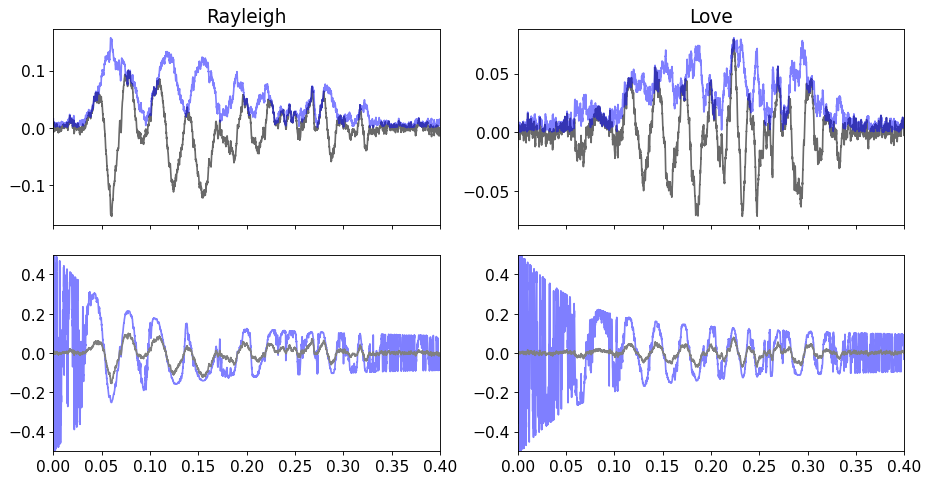

In [47]:
fig, axes = plt.subplots(2,2, figsize=(14, 6), dpi=80, sharex=True, 
                        gridspec_kw = dict( left = 0.18, right = 0.94, bottom = 0.1, top = 0.98, hspace = 0.15))

axes[0,0].plot(NCF_f, Ray_NCF, 'dimgray')
axes[0,0].plot(NCF_f, Ray_HilbEnve, 'b', alpha = 0.5)
axes[0,0].set_title('Rayleigh')
axes[0,0].set_xlim([0, 0.4])

axes[0,1].plot(NCF_f, Love_NCF, 'dimgray')
axes[0,1].plot(NCF_f, Love_HilbEnve, 'b', alpha = 0.5)
axes[0,1].set_title('Love')

axes[1,0].plot(NCF_f, Ray_NCFHilb, 'b', alpha = 0.5)
axes[1,0].plot(NCF_f, Ray_NCF, 'gray')
axes[1,0].set_ylim([-0.5, 0.5])

axes[1,1].plot(NCF_f, Love_NCFHilb, 'b', alpha = 0.5)
axes[1,1].plot(NCF_f, Love_NCF, 'gray')
axes[1,1].set_ylim([-0.5, 0.5])

In [48]:
nnlayer = 4
nnneuoron = 40

freqmax = 4500
freqmin = 359

#### [Rayleigh Wave] ####
RayWave = 1

# set the hyperparameters for the loss function
Lambdas = [1e0, 1e-8] # weight for different loss terms

# get the median to set the range of possible phase velocity
c_median = get_cw_median(NCF_f, RayWave)[freqmin:freqmax]

input_NCF = torch.from_numpy(Ray_NCFHilb[freqmin:freqmax]).float().reshape(-1,1)
input_NCF.requires_grad = True

# set the input_f so that can compute the gradient of PV in the loss function
input_f = torch.from_numpy(NCF_f[freqmin:freqmax]).float().reshape(-1,1)
input_f.requires_grad = True
input_f.allow_unused = True

# train the PINN
infer_PV_Ray, infer_Bessel_Ray, history_Ray, Model_Ray = train_PINN(input_f, input_NCF, RayWave, 
                                                      Lambdas, stadist, c_median, nnlayer, float(1), nnneuoron)

#### [Love Wave] ####
RayWave = 0

# set the hyperparameters for the loss function
Lambdas = [1e0, 1e-8] # weight for different loss terms

# get the median to set the range of possible phase velocity
c_median = get_cw_median(NCF_f, RayWave)[freqmin:freqmax]

input_NCF = torch.from_numpy(Love_NCFHilb[freqmin:freqmax]).float().reshape(-1,1)
input_NCF.requires_grad = True

# set the input_f so that can compute the gradient of PV in the loss function
input_f = torch.from_numpy(NCF_f[freqmin:freqmax]).float().reshape(-1,1)
input_f.requires_grad = True
input_f.allow_unused = True

# train the PINN
infer_PV_Love, infer_Bessel_Love, history_Love, Model_Love = train_PINN(input_f, input_NCF, RayWave, 
                                                      Lambdas, stadist, c_median, nnlayer, float(1), nnneuoron)

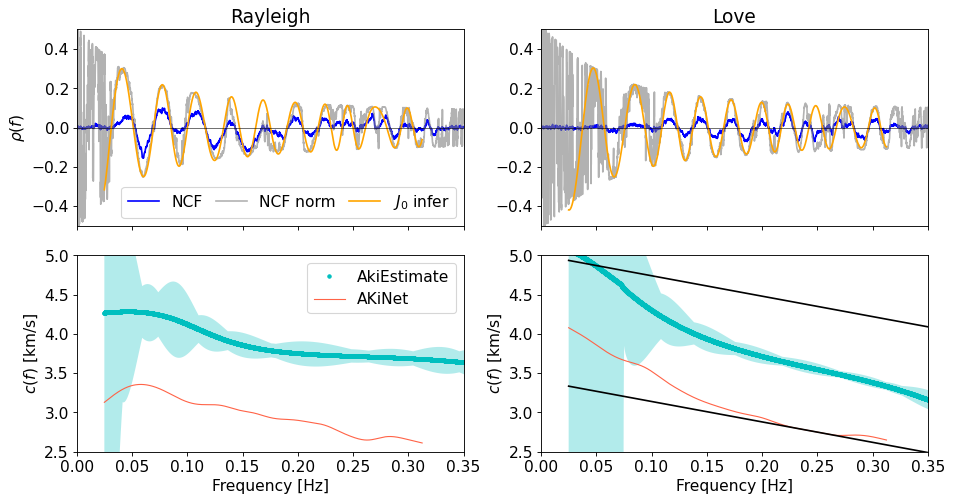

In [49]:
plot_f = input_f.detach().numpy()[:,0]

# Plot the obtained curves
matplotlib.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(2,2, figsize=(14, 6), dpi=80, sharex=True, 
                        gridspec_kw = dict( left = 0.18, right = 0.94, bottom = 0.1, top = 0.98, hspace = 0.15))


axes[0,0].plot(NCF_f, Ray_NCF, 'b', label='NCF')
# axes[1].plot(pred_f, pred_J0, 'g', alpha = 0.6, label='ADAMA $J_0$')
axes[0,0].plot(NCF_f,  Ray_NCFHilb, 'gray', alpha = 0.6, label='NCF norm')
axes[0,0].plot(plot_f, infer_Bessel_Ray.detach().numpy()[:,0], 'orange', label='$J_0$ infer')
axes[0,0].axhline(y = 0, linewidth = 0.5, color='k')
axes[0,0].set_ylabel(r'$\rho(f)$')
axes[0,0].set_title('Rayleigh')
axes[0,0].legend(ncol=3, loc='lower right', columnspacing=0.85)
axes[0,0].set_xlim([0, 0.35])
axes[0,0].set_ylim([-0.5, 0.5])

axes[0,1].plot(NCF_f, Love_NCF, 'b', label='NCF')
# axes[1].plot(pred_f, pred_J0, 'g', alpha = 0.6, label='ADAMA $J_0$')
axes[0,1].plot(NCF_f,  Love_NCFHilb, 'gray', alpha = 0.6, label='NCF norm')
axes[0,1].plot(plot_f, infer_Bessel_Love.detach().numpy()[:,0], 'orange', label='$J_0$ infer')
axes[0,1].axhline(y = 0, linewidth = 0.5, color='k')
axes[0,1].set_title('Love')
axes[0,1].set_ylim([-0.5, 0.5])
# axes[0,1].legend(ncol=3, loc='lower right', columnspacing=0.85)

axes[1,0].plot(pred_f, pred_RPV, 'c.', label='AkiEstimate')
axes[1,0].fill_between(UncerRay[:,0], UncerRay[:,1], UncerRay[:,2] ,alpha=0.3, facecolor='c')
axes[1,0].plot(plot_f, infer_PV_Ray.detach().numpy()[:,0], label='AKiNet', linewidth=1, color='tomato')
axes[1,0].set_xlabel('Frequency [Hz]')
axes[1,0].set_ylabel(r'$c(f)$ [km/s]')
axes[1,0].set_ylim([2.5, 5])
axes[1,0].legend()

axes[1,1].plot(pred_f, pred_LPV, 'c.', label='AkiEstimate')
axes[1,1].fill_between(UncerLove[:,0], UncerLove[:,1], UncerLove[:,2] ,alpha=0.3, facecolor='c')
axes[1,1].plot(plot_f, infer_PV_Love.detach().numpy()[:,0], label='AKiNet', linewidth=1, color='tomato')
axes[1,1].plot(np.array([0.025, 0.35]), get_cw_median(np.array([0.025, 0.35]), 0) + 0.8, 'k')
axes[1,1].plot(np.array([0.025, 0.35]), get_cw_median(np.array([0.025, 0.35]), 0) - 0.8, 'k')
axes[1,1].set_xlabel('Frequency [Hz]')
axes[1,1].set_ylabel(r'$c(f)$ [km/s]')
axes[1,1].set_ylim([2.5, 5]);


# [3] Assemble the Plots together 

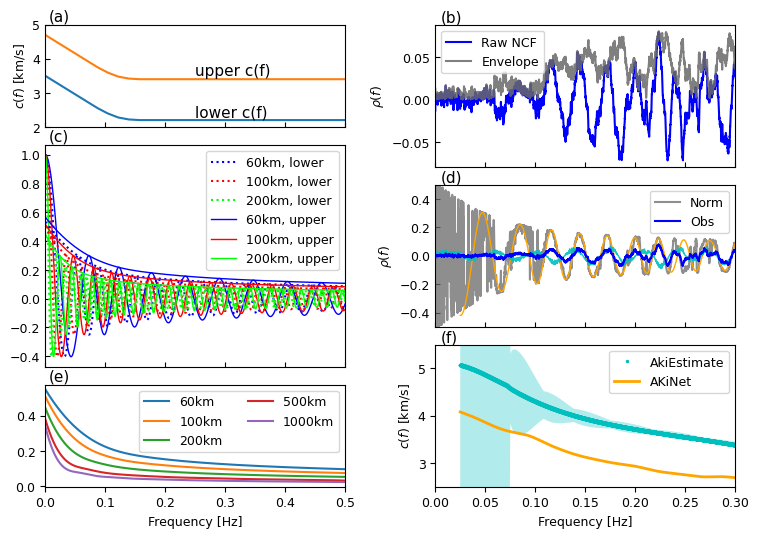

In [55]:
plt.figure(figsize=(7.5, 5.5))
matplotlib.rcParams.update({'font.size': 9})

# create the figure layout
ax1 = plt.subplot2grid((12, 2), (0, 0), colspan=1, rowspan=3)
ax2 = plt.subplot2grid((12, 2), (3, 0), colspan=1, rowspan=6)
ax3 = plt.subplot2grid((12, 2), (9, 0), colspan=1, rowspan=3)
ax4 = plt.subplot2grid((12, 2), (0, 1), colspan=1, rowspan=4)
ax5 = plt.subplot2grid((12, 2), (4, 1), colspan=1, rowspan=4)
ax6 = plt.subplot2grid((12, 2), (8, 1), colspan=1, rowspan=4)
plt.subplots_adjust(left = 0.05, right = 0.97, bottom = 0.11, top = 0.95, wspace=0.3, hspace=0.8)  # spacing between subplots

### plot the upper & lower phase velocities used in computing Bessel envelopes
ax1.plot(Bessel_f, cw_lower)
ax1.plot(Bessel_f, cw_upper)
ax1.text(0.006,5.1, '(a)', fontsize=11, color='k')
ax1.text(0.25, 3.5, 'upper c(f)', fontsize=11, color='k')
ax1.text(0.25, 2.3, 'lower c(f)', fontsize=11, color='k')
ax1.set_xlim([0, 0.5])
ax1.set_ylim([2, 5])
ax1.set_xticklabels([])
ax1.tick_params(direction="in")
ax1.set_ylabel(r'$c(f)$ [km/s]')

### plot the Bessel & Bessel envelopes
ax2.plot(Bessel_f, Bessel1, 'b:', label='60km, lower')
ax2.plot(Bessel_f, Bessel2, 'r:', label='100km, lower')
ax2.plot(Bessel_f, Bessel3, 'lime', linestyle=':', label='200km, lower')

ax2.plot(Bessel_f, Bessel4, 'b', label='60km, upper', linewidth=1)
ax2.plot(Bessel_f, Bessel5, 'r', label='100km, upper', linewidth=1)
ax2.plot(Bessel_f, Bessel6, 'lime', label='200km, upper', linewidth=1)

ax2.plot(Bessel_f, PEnv1, 'b:')
ax2.plot(Bessel_f, PEnv2, 'r:')
ax2.plot(Bessel_f, PEnv3, 'lime', linestyle=':')

ax2.plot(Bessel_f, PEnv4, 'b', linewidth=1)
ax2.plot(Bessel_f, PEnv5, 'r', linewidth=1)
ax2.plot(Bessel_f, PEnv6, 'lime', linewidth=1)

ax2.text(0.006, 1.1, '(c)', fontsize=11, color='k')
ax2.legend(ncol=1)
ax2.set_xlim([0, 0.5])
ax2.set_xticklabels([])
ax2.tick_params(direction="in")

### plot Bessel avg envelope for r = 60km to 220km
plot_dist = np.array([60, 100, 200, 500, 1000])
for i in range(len(plot_dist)):
    dist = plot_dist[i]

    Bessello = sp.jv(0, Bessel_f*dist*2*np.pi / cw_lower)
    Besselup = sp.jv(0, Bessel_f*dist*2*np.pi / cw_upper)

    enveup, temp = peak_envelope(Besselup, 50, 3)
    envelo, temp = peak_envelope(Bessello, 50, 3)

    # get the average of Bessel envelopes using the upper & lower phase velocities
    enveavg = (enveup + envelo) /2

    ax3.plot(Bessel_f, enveavg, label=str(dist)+'km')

ax3.text(0.006, 0.6, '(e)', fontsize=11, color='k')
ax3.legend(ncol=2)
ax3.set_xlim([0, 0.5])
ax3.set_xlabel('Frequency [Hz]')

### plot the raw NCF & its Hilbert Envelope
ax4.plot(NCF_f, Love_NCF, 'b', label='Raw NCF')
ax4.plot(NCF_f, Love_HilbEnve, 'dimgray', alpha = 0.85, label='Envelope')
ax4.text(0.006, 0.091, '(b)', fontsize=11, color='k')
ax4.legend()
ax4.set_xticklabels([])
ax4.tick_params(direction="in")
ax4.set_ylabel(r'$\rho(f)$')
ax4.set_xlim([0, 0.3])

### plot the normalized & the raw NCFs
ax5.plot(NCF_f, Love_NCFHilb, 'dimgray', alpha = 0.75, label='Norm')
ax5.plot(plot_f, infer_Bessel_Love.detach().numpy()[:,0], 'orange', linewidth=1)
ax5.plot(pred_f, pred_LJ0, 'c', alpha = 0.9, linewidth=1)
ax5.plot(NCF_f, Love_NCF, 'b', label='Obs')
ax5.text(0.006, 0.517, '(d)', fontsize=11, color='k')
ax5.set_ylabel(r'$\rho(f)$')
ax5.set_xticklabels([])
ax5.tick_params(direction="in")
ax5.set_xlim([0, 0.3])
ax5.set_ylim([-0.5, 0.5])
ax5.legend()

ax6.plot(pred_f, pred_LPV, 'c.', label='AkiEstimate', markersize=3)
ax6.fill_between(UncerLove[:,0], UncerLove[:,1], UncerLove[:,2] ,alpha=0.3, facecolor='c')
ax6.plot(plot_f, infer_PV_Love.detach().numpy()[:,0], label='AKiNet', linewidth=2, color='orange')
ax6.text(0.006, 5.55, '(f)', fontsize=11, color='k')
ax6.set_xlim([0, 0.3])
ax6.set_ylim([2.5, 5.5])
ax6.set_xlabel('Frequency [Hz]')
ax6.set_ylabel(r'$c(f)$ [km/s]')
ax6.legend();

# plt.savefig( './Figures/S1_Envelope.pdf', dpi = 400, facecolor = 'w' )